### Your name:

<pre> Lilian Li</pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [36]:
pathToFile = r"C:\\Users\\theli\\Documents\\3253 - Machine Learning\\Assignments\\datasets\\LD2011_2014\\"
fileName = 'LD2011_2014.txt'

In [110]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [38]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [39]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [40]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [42]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [44]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

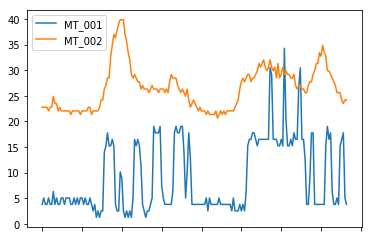

In [45]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [46]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [47]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [48]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [49]:
clients = data2011.columns
#print(clients)
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand in 2013
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand (columns)
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [50]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [51]:
data['hour'] = data.index.map(lambda x: x[11:])
print(data.head())

                       MT_001     MT_002    MT_003      MT_004     MT_005  \
2013-01-01 00:15:00  2.538071  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:30:00  1.269036  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:45:00  2.538071  22.759602  2.606429  134.146341  60.975610   
2013-01-01 01:00:00  1.269036  23.470839  2.606429  130.081301  56.097561   
2013-01-01 01:15:00  3.807107  23.470839  2.606429  130.081301  58.536585   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2013-01-01 00:15:00  255.952381  4.522329  239.057239  57.692308  78.494624   
2013-01-01 00:30:00  264.880952  5.652911  228.956229  57.692308  76.344086   
2013-01-01 00:45:00  250.000000  5.652911  239.057239  54.195804  76.344086   
2013-01-01 01:00:00  226.190476  6.218202  249.158249  50.699301  75.268817   
2013-01-01 01:15:00  229.166667  6.783493  239.057239  57.692308  74.193548   

                       ...      MT_362      MT_363       MT_36

In [52]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [80]:
datagrouped = data.groupby("hour")
#print(datagrouped.head())
average_curves = datagrouped.agg("mean")
print(average_curves.head())
average_curves.shape 

            MT_001     MT_002    MT_003      MT_004     MT_005      MT_006  \
hour                                                                         
00:00:00  5.008344  26.045909  1.938755  130.551843  60.374206  191.136660   
00:15:00  4.917947  25.833512  1.911381  125.863125  57.586034  179.297130   
00:30:00  4.984007  24.754964  1.909001  121.566990  55.476111  171.554958   
00:45:00  4.980530  24.656560  1.899480  117.961354  53.630137  164.452870   
01:00:00  4.963146  23.665699  1.863775  111.732932  52.123288  155.850457   

            MT_007      MT_008     MT_009     MT_010      ...       \
hour                                                      ...        
00:00:00  7.772366  242.027582  51.585401  54.837237      ...        
00:15:00  7.426996  232.516950  50.016764  53.424658      ...        
00:30:00  7.179972  225.317098  48.843280  52.514361      ...        
00:45:00  7.013482  218.698400  47.574001  51.150390      ...        
01:00:00  6.843894  212.291868  4

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [54]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

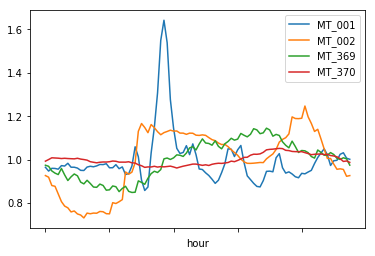

In [55]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [135]:
X = average_curves_norm.copy()
print(X.head())

X = np.array(X.T) # put it on the right format

print(X)

            MT_001    MT_002    MT_003    MT_004    MT_005    MT_006  \
hour                                                                   
00:00:00  0.964792  0.926674  0.991800  1.140106  1.186498  1.008914   
00:15:00  0.947378  0.919117  0.977796  1.099159  1.131703  0.946419   
00:30:00  0.960104  0.880744  0.976579  1.061641  1.090238  0.905552   
00:45:00  0.959434  0.877243  0.971708  1.030153  1.053960  0.868064   
01:00:00  0.956085  0.841989  0.953443  0.975761  1.024347  0.822656   

            MT_007    MT_008    MT_009    MT_010    ...       MT_361  \
hour                                                ...                
00:00:00  1.170686  0.946572  0.983915  0.948867    ...     0.414676   
00:15:00  1.118666  0.909376  0.953996  0.924425    ...     0.414381   
00:30:00  1.081459  0.881217  0.931614  0.908674    ...     0.386706   
00:45:00  1.056382  0.855331  0.907404  0.885073    ...     0.337499   
01:00:00  1.030838  0.830275  0.888265  0.869041    ...     0.3

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice


19


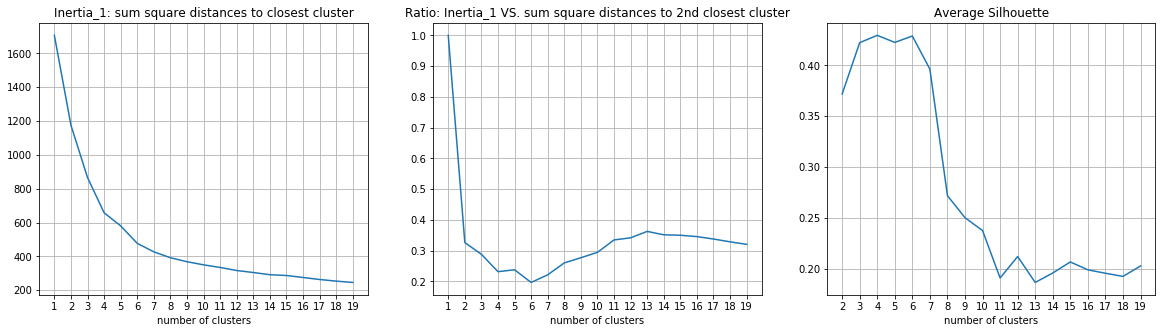

In [136]:
#a)
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

inertias_1 = []
inertias_2 = []
silhouette_avgs = []
import math
max_K = math.ceil(math.sqrt(len(average_curves_norm.columns)))
print(max_K)
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

        
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

by intertia we use the elbow method and choose 6, inertia2 method will look for the minimum k which is also 6.
Silhouette will suggest the maximum value - 4 or 6.
We choose 6 as the optimum k value using these methods.

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

0


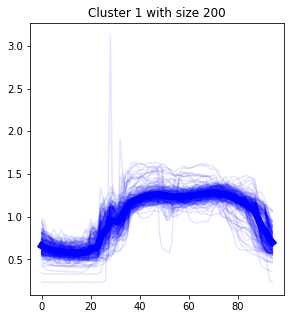

1


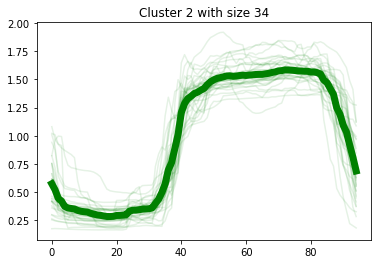

2


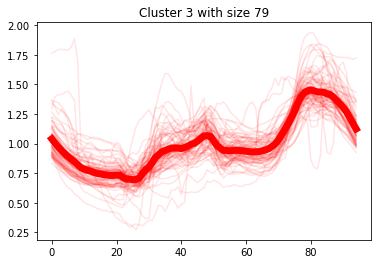

3


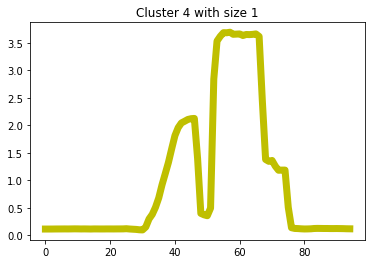

4


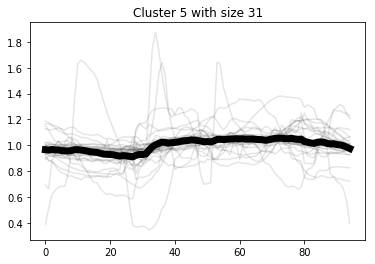

5


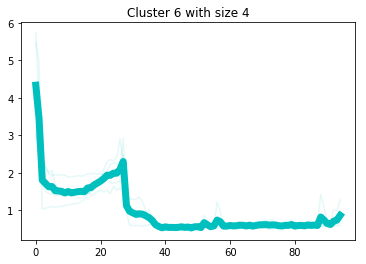

In [139]:
colors = 'bgrykcm'
trueK = 6
kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)
centroids = np.array(kmeans.cluster_centers_)
#print(kmeans.labels_)

plt.figure(figsize=(10,5))  
plt.subplot(1,2,2)  
    
for J in range(trueK):
    print(J)
    X_J = X[kmeans.labels_==J]
    sz = (len(X[kmeans.labels_==J]))
    plt.plot(X_J[:, 1:].transpose(), c=colors[J], alpha=0.1)
    plt.title("Cluster "+str(J+1)+" with size "+ str(sz))
    #plt.xlim(-0.2,1.2)
    #plt.ylim(-0.2,1.2)
    #plt.axis('equal')
    plt.plot(centroids[:,1:][J].transpose(), c=colors[J], linewidth=7.0)
    plt.show()    


## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

28


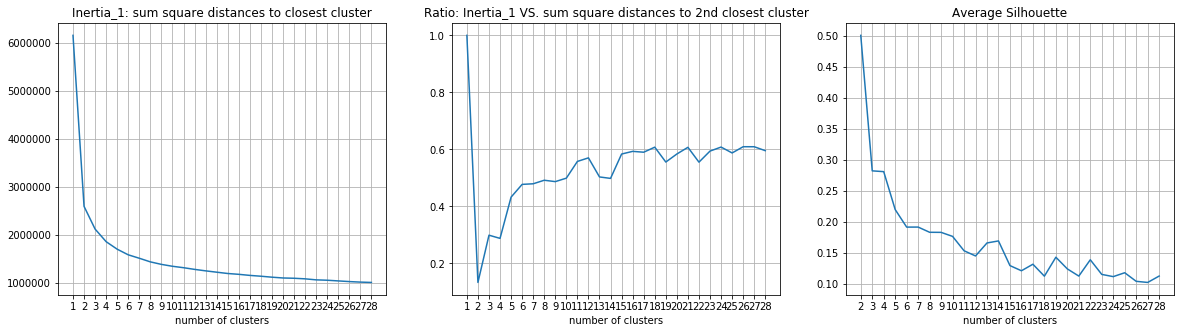

In [157]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
#print(len(X))
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
import math
max_K = math.ceil(math.sqrt(len(X)))
print(max_K)
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

        
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

from inertia 1, inertia 2, and silhouette we choose K = 2

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [167]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
wkdays = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])
    wkdays.extend([D[(d1 + timedelta(days=i)).weekday()]])

#print(daysyear)
print(len(daysyear))

730


#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [168]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]

In [169]:
X = np.squeeze(X) 
#print(X)


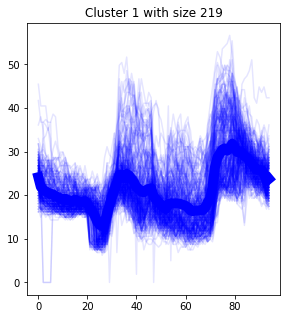

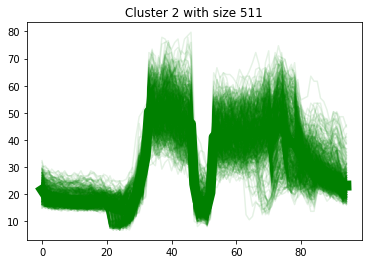

In [170]:
colors = 'bgrykcm'
trueK = 2
kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)
centroids = np.array(kmeans.cluster_centers_)
#print(kmeans.labels_)

plt.figure(figsize=(10,5))  
plt.subplot(1,2,2)  
    
for J in range(trueK):
    #print(J)
    X_J = X[kmeans.labels_==J]
    sz = (len(X[kmeans.labels_==J]))
    plt.plot(X_J[:, 1:].transpose(), c=colors[J], alpha=0.1)
    plt.title("Cluster "+str(J+1)+" with size "+ str(sz))
    #plt.xlim(-0.2,1.2)
    #plt.ylim(-0.2,1.2)
    #plt.axis('equal')
    plt.plot(centroids[:,1:][J].transpose(), c=colors[J], linewidth=10)
    plt.show()    


In [176]:
for J in range(trueK):
    print("Cluster "+str(J+1))
    #print(list(compress(daysyear, kmeans.labels_==J)))
    my_series = pd.Series(list(compress(wkdays, kmeans.labels_==J)))
    print(my_series.value_counts())

Cluster 1
sun    104
sat     58
wed     12
tue     12
mon     12
fri     11
thu     10
dtype: int64
Cluster 2
thu    94
wed    93
fri    93
tue    93
mon    92
sat    46
dtype: int64


cluster 1 represents weekends (majority of time series are from Sat/Sun) and cluster 2 represent week days from looking at the distribution of the day names inside the clusters.